In [6]:
import networkx as nx
import itertools
from ortools.linear_solver import pywraplp

In [7]:
def eliminacao_ciclos(G, centrais):    
    # Cria um solver
    solver = pywraplp.Solver.CreateSolver('SCIP')

    # Cria as variáveis de decisão
    x = {}
    for u, v in G.edges():
        x[u, v] = solver.IntVar(0, 1, f'x[{u},{v}]')
        x[v,u] = x[u,v]  # arestas não direcionadas

    # Define a função objetivo (minimizar peso total)
    objective = solver.Objective()
    for u, v in G.edges():
        objective.SetCoefficient(x[u, v], G[u][v]['weight'])
    objective.SetMinimization()

    # Adiciona as restrições
    # Restrição 1: Eliminação de ciclos
    for C in nx.cycle_basis(G):
        constraint = solver.Constraint(len(C) - 1, len(C) - 1)
        added_edges = set()
        for u, v in G.subgraph(C).edges():
            if (u, v) not in added_edges:
                constraint.SetCoefficient(x[u, v], 1)
                added_edges.add((u, v))

    # Restrição 2: Limitação de grau para subconjuntos de vértices
    for S in itertools.combinations(G.nodes(), 2):
        constraint = solver.Constraint(0, len(S) - 1)
        for u, v in G.edges():
            if u in S and v in S:
                constraint.SetCoefficient(x[u, v], 1)

    # Restrição 3: Grau mínimo para vértices centrais
    for v, degree in centrais.items():
        constraint = solver.Constraint(degree, solver.infinity())
        for u in G.neighbors(v):
            constraint.SetCoefficient(x[u, v], 1)

    # Restrição 4: Uma aresta incidente por terminal (exceto a raiz)
    root = min(centrais, key=lambda v: len(list(G.neighbors(v))))
    for v in centrais:
        if v != root:
            constraint = solver.Constraint(1, 1)
            for u in G.neighbors(v):
                constraint.SetCoefficient(x[u, v], 1)


    solver.set_time_limit(600000)  # Limite de tempo de 10 minutos (600.000 milissegundos)

    # Resolve o problema
    status = solver.Solve()

    # Verifica se a solução é ótima
    if status == pywraplp.Solver.OPTIMAL:
        # Extrai a solução e constrói a árvore geradora
        T = nx.Graph()
        for u, v in G.edges():
            if x[u, v].solution_value() == 1:
                T.add_edge(u, v)
        return T, solver.WallTime()
    else:
        print('A solução não é ótima.')
        return None, solver.WallTime()

In [8]:
# Função para ler as instâncias do problema
def ler_instancia(caminho_arquivo):
    with open(caminho_arquivo, 'r') as f:
        # Ler a primeira linha (n, nc, m)
        primeira_linha = f.readline().strip().split()
        n = int(primeira_linha[0])
        nc = int(primeira_linha[1])
        m = int(primeira_linha[2])
        
        # Inicializar o grafo
        G = nx.Graph()
        
        # Ler os vértices centrais e seus graus mínimos
        centrais = {}
        for _ in range(nc):
            linha = f.readline().strip().split()
            vertice_central = int(linha[0])
            grau_minimo = int(linha[1])
            centrais[vertice_central] = grau_minimo
        
        # Ler as arestas e os custos
        for _ in range(m):
            linha = f.readline().strip().split()
            i = int(linha[0])
            j = int(linha[1])
            custo = int(linha[2])
            G.add_edge(i, j, weight=custo)   
    return G, centrais

In [9]:
def criar_grafo_exemplo():
    # Criar um grafo simples com 6 nós e algumas arestas com pesos
    G = nx.Graph()
    edges = [
        (0, 1, 4), (0, 2, 3), (1, 2, 2), (1, 3, 5), 
        (2, 3, 7), (2, 4, 6), (3, 4, 2), (3, 5, 8)
    ]
    for u, v, weight in edges:
        G.add_edge(u, v, weight=weight)
    
    # Definir os vértices centrais e seus graus mínimos
    centrais = {0: 2, 3: 2}
    return G, centrais

A solução não é ótima.
Tempo de execução: 2.00 segundos


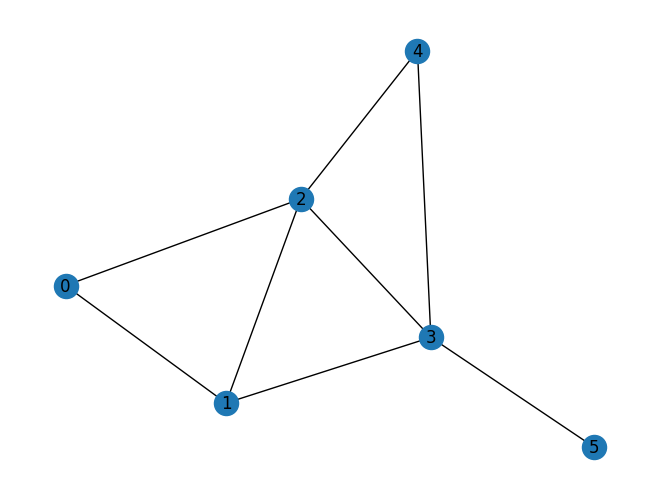

In [10]:
# path = "instancias/tb8ch4_0.txt"
G, centrais = criar_grafo_exemplo()
nx.draw(G, with_labels=True)
T, tempo = eliminacao_ciclos(G, centrais)
if T is not None:
    nx.draw(T, with_labels=True)

print(f'Tempo de execução: {tempo:.2f} segundos')
